# Fine-Tuning Language Models

This notebook is a supplementary material for the Fine-Tuning Language Models of the [Hands-On Generative AI with Transformers and Diffusion Models book](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/). This notebook includes:

* The code from the book
* Additional examples
* Exercise solutions

## Classifying Text


In [ ]:
import datasets
import numpy as np
import torch
import transformers

np.set_printoptions(edgeitems=10, linewidth=70)
torch.set_printoptions(edgeitems=10, linewidth=70)


transformers.logging.set_verbosity_warning()
datasets.logging.set_verbosity_error()

### 1. Identify a Dataset


In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("fancyzhx/ag_news")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [ ]:
print(raw_train_dataset.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}


### 4. Pre-process the Dataset

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,
          1996,  2304,  1006, 26665,  1007, 26665,  1011,  2460,
          1011, 19041,  1010,  2813,  2395,  1005,  1055,  1040,
         11101,  2989,  1032,  2316,  1997, 11087,  1011, 22330,
          8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006,
         26665,  1007, 26665,  1011,  2797,  5211,  3813, 18431,
          2571,  2177,  1010,  1032,  2029,  2038,  1037,  5891,
          2005,  2437,  2092,  1011, 22313,  1998,  5681,  1032,
          6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,
          1997,  1996,  3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

### 5. Define evaluation metrics


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
print(accuracy.description)
print(accuracy.compute(references=[0, 1, 0, 1], predictions=[1, 0, 0, 1]))


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

{'accuracy': 0.5}


In [ ]:
f1_score = evaluate.load("f1")


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute F1 score and accuracy
    f1 = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )[
        "f1"
    ]
    acc = accuracy.compute(references=labels, predictions=preds)[
        "accuracy"
    ] 

    return {"accuracy": acc, "f1": f1}

### 6. Train the Model


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

batch_size = 32  # You can change this if you have a big or small GPU
training_args = TrainingArguments(
    "example-classifier",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
)

In [ ]:
from transformers import Trainer

shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

  0%|          | 0/626 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 0.26820164918899536, 'eval_accuracy': 0.911578947368421, 'eval_f1': 0.9113116366931407, 'eval_runtime': 14.5833, 'eval_samples_per_second': 521.144, 'eval_steps_per_second': 16.32, 'epoch': 1.0}
{'loss': 0.3048, 'grad_norm': 2.9898579120635986, 'learning_rate': 1.0063897763578276e-05, 'epoch': 1.6}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 0.24525779485702515, 'eval_accuracy': 0.921578947368421, 'eval_f1': 0.9215476836025032, 'eval_runtime': 14.3092, 'eval_samples_per_second': 531.127, 'eval_steps_per_second': 16.633, 'epoch': 2.0}
{'train_runtime': 215.0787, 'train_samples_per_second': 92.989, 'train_steps_per_second': 2.911, 'train_loss': 0.27957692313879823, 'epoch': 2.0}


TrainOutput(global_step=626, training_loss=0.27957692313879823, metrics={'train_runtime': 215.0787, 'train_samples_per_second': 92.989, 'train_steps_per_second': 2.911, 'total_flos': 1875180164398464.0, 'train_loss': 0.27957692313879823, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osanseviero/example-classifier/commit/38a3debcc94f138f2f0a16962b380b6ee19162f3', commit_message='End of training', commit_description='', oid='38a3debcc94f138f2f0a16962b380b6ee19162f3', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model="osanseviero/example-classifier")
pipe(
    """The soccer match between Spain and 
Portugal ended in a terrible result for Portugal."""
)

config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9540880918502808}]

In [ ]:
tokenized_datasets["test"].select([0, 1, 2])

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3
})

In [ ]:
# Run inference for all samples
trainer_preds = trainer.predict(tokenized_datasets["test"])

# Get the most likely class and the target label
preds = trainer_preds.predictions.argmax(-1)
references = trainer_preds.label_ids
label_names = raw_train_dataset.features["label"].names

  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
# Print results of the first 3 samples
samples = 3
texts = tokenized_datasets["test"]["text"][:samples]

for pred, ref, text in zip(preds[:samples], references[:samples], texts):
    print(f"Predicted {pred}; Actual {ref}; Target name: {label_names[pred]}.")
    print(text)

Predicted 2; Actual 2; Target name: Business.
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted 3; Actual 3; Target name: Sci/Tech.
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Predicted 3; Actual 3; Target name: Sci/Tech.
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.


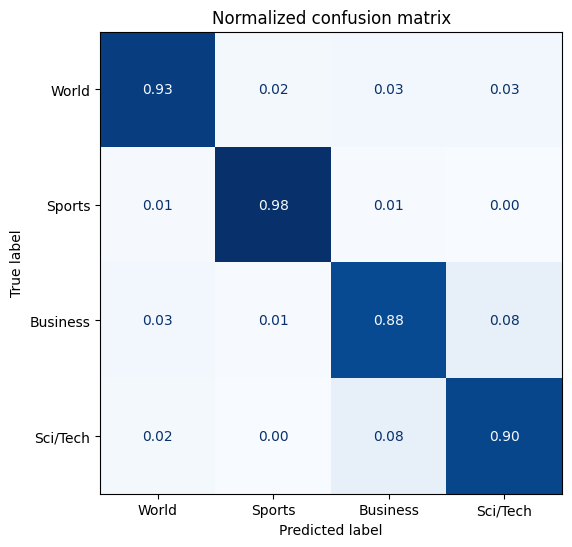

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=preds, normalize="true"
)["confusion_matrix"]

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

plt.title("Normalized confusion matrix")
plt.show()

## Generating text


In [ ]:
filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForCausalLM

model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = (
    tokenizer.eos_token
)  # Needed as gpt2 does not specify padding token.
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

In [ ]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1900
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
samples = [tokenized_datasets["train"][i] for i in range(3)]

for sample in samples:
    print(f"input_ids shape: {len(sample['input_ids'])}")

input_ids shape: 37
input_ids shape: 55
input_ids shape: 51


In [ ]:
out = data_collator(samples)
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([3, 55])
attention_mask shape: torch.Size([3, 55])
labels shape: torch.Size([3, 55])


In [ ]:
training_args = TrainingArguments(
    "sft_extra",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
)

In [ ]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    eval_dataset=tokenized_datasets["test"],
)

In [ ]:
trainer.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 3.66, 'grad_norm': 2.427961826324463, 'learning_rate': 0.0004690766700109659, 'epoch': 0.32}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.5981976985931396, 'eval_runtime': 4.4414, 'eval_samples_per_second': 427.789, 'eval_steps_per_second': 53.586, 'epoch': 0.32}
{'loss': 3.319, 'grad_norm': 2.11116099357605, 'learning_rate': 0.00038395669874474915, 'epoch': 0.64}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.486621618270874, 'eval_runtime': 4.5551, 'eval_samples_per_second': 417.119, 'eval_steps_per_second': 52.25, 'epoch': 0.64}
{'loss': 3.1101, 'grad_norm': 2.622725486755371, 'learning_rate': 0.0002656976298823284, 'epoch': 0.96}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.3663034439086914, 'eval_runtime': 4.5256, 'eval_samples_per_second': 419.838, 'eval_steps_per_second': 52.59, 'epoch': 0.96}
{'loss': 2.1529, 'grad_norm': 2.4595162868499756, 'learning_rate': 0.00014355517710873183, 'epoch': 1.28}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.443877696990967, 'eval_runtime': 4.5249, 'eval_samples_per_second': 419.902, 'eval_steps_per_second': 52.598, 'epoch': 1.28}
{'loss': 1.9697, 'grad_norm': 2.027958393096924, 'learning_rate': 4.7745751406263163e-05, 'epoch': 1.6}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.4080607891082764, 'eval_runtime': 4.5391, 'eval_samples_per_second': 418.589, 'eval_steps_per_second': 52.434, 'epoch': 1.6}
{'loss': 1.9158, 'grad_norm': 2.5547542572021484, 'learning_rate': 1.9713246713805587e-06, 'epoch': 1.92}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.397428274154663, 'eval_runtime': 4.6038, 'eval_samples_per_second': 412.703, 'eval_steps_per_second': 51.696, 'epoch': 1.92}
{'train_runtime': 139.9855, 'train_samples_per_second': 71.436, 'train_steps_per_second': 8.929, 'train_loss': 2.6575397399902343, 'epoch': 2.0}


TrainOutput(global_step=1250, training_loss=2.6575397399902343, metrics={'train_runtime': 139.9855, 'train_samples_per_second': 71.436, 'train_steps_per_second': 8.929, 'total_flos': 467451445248000.0, 'train_loss': 2.6575397399902343, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osanseviero/sft_extra/commit/fc112a32b79b379c8af88607db6b96f601d1c934', commit_message='End of training', commit_description='', oid='fc112a32b79b379c8af88607db6b96f601d1c934', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model="osanseviero/sft_extra", device=device)
pipe.tokenizer.pad_token_id = 50256  # pad_token_id for gpt2
print(pipe("Q1", pad_token_id=tokenizer.eos_token_id)[0]["generated_text"])
print(pipe("Wall", pad_token_id=tokenizer.eos_token_id)[0]["generated_text"])
print(pipe("Google", pad_token_id=tokenizer.eos_token_id)[0]["generated_text"])

model.safetensors:  57%|#####6    | 283M/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

Q1-Gains on pace of increase in revenue -WSJ US insurers Q1 has doubled the number of claims for its insurance-insurance-busting service, in an effort to shift the burden of insurance onto its customers. Q1
Wall Street Gains on Labor Day (Reuters) Reuters - U.S. stocks gained in quiet trading\on Thursday following a sharp drop in oil prices, but gains continued\over the Labor Day holiday, with the market opening at a 45-
Google gets goaded down on profit warning LONDON: The European Commission has decided not to give Google Inc. its initial public offering a full price warning, saying the IPO deal lacked marketability. Google shares had their market debut Friday afternoon over fears it


## A quick introduction to adapters

In [ ]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
    fan_in_fan_out=True,
)

model = AutoModelForCausalLM.from_pretrained("gpt2")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.23643136409814364


## A light introduction to quantization

In [ ]:
model = AutoModelForCausalLM.from_pretrained("gpt2", torch_dtype=torch.float16)

In [ ]:
def scaling_factor(vector):
    m = np.max(np.abs(vector))
    return 127 / m


array = [1.2, -0.5, -4.3, 1.2, -3.1, 0.8, 2.4, 5.4]
alpha = scaling_factor(array)
quantized_array = np.round(alpha * np.array(array)).astype(np.int8)
dequantized_array = quantized_array / alpha

print(f"Scaling factor: {alpha}")
print(f"Quantized array: {quantized_array}")
print(f"Dequantized array: {dequantized_array}")
print(f"Difference: {array - dequantized_array}")

Scaling factor: 23.518518518518515
Quantized array: [  28  -12 -101   28  -73   19   56  127]
Dequantized array: [ 1.19055118 -0.51023622 -4.29448819  1.19055118 -3.10393701
  0.80787402  2.38110236  5.4       ]
Difference: [ 0.00944882  0.01023622 -0.00551181  0.00944882  0.00393701
 -0.00787402  0.01889764  0.        ]


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained("gpt2", quantization_config=quantization_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


## All together


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1",
    quantization_config=quantization_config,
    device_map="auto",
)

In [ ]:
from trl import SFTTrainer
from datasets import load_dataset 
from transformers import TrainingArguments
from peft import LoraConfig

dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

training_args = TrainingArguments(
    "fine_tune_e2e",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    gradient_checkpointing=True,
)

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset.select(range(300)),
    dataset_text_field="text",
    peft_config=peft_config,
    max_seq_length=512,
)

trainer.train()

In [ ]:
trainer.push_to_hub()

In [ ]:
from peft import PeftModel

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1",
    quantization_config=quantization_config,
    device_map="auto",
)
model = PeftModel.from_pretrained(
    model,
    "osanseviero/fine_tune_e2e",
    torch_dtype=torch.float16,
) 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model = model.merge_and_unload()  # This is the main difference

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
print(pipe("### Human: Hello!###Assistant:", max_new_tokens=100)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Human: Hello!###Assistant: Hello! How can I help you?###Human: I want to know how to make a website.###Assistant: Sure! Here are some steps to help you get started:

1. Choose a domain name and web hosting provider.
2. Install a content management system (CMS) like WordPress or Joomla.
3. Customize the design and layout of your website.
4. Create and publish content, such as blog posts, articles, or product


**6. Why does QLoRA lead to slower training?**

QLoRA needs to quantize the weights and activations. During training, the quantized parameters often need to be dequantized back to higher precision, which creates an overhead in terms of latency.


**7. In which cases do we freeze the model weights during fine-tuning?**

Some examples:

* If we use PEFT techniques, we often freeze the base model and just update the adapter weights.


## Exercises

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the solutions before taking a stab at the problem. Scroll down for th answers

**1. What's the difference between base and fine-tuned models? What kind of model is a conversational one?** 

* **Base models:** Base models are models that are trained on a large dataset to perform general language modeling tasks. They serve as the model that can be further adapted to specific tasks.
* **Fine-tuned models:**  Fine-tuned models are derived from base models by training them further on a smaller, more specific dataset tailored for a particular task or domain. Fine-tuning adjusts the pretrained model's parameters to enhance its performance in specialized areas. Examples include models fine-tuned for summarization, text classification, named entity recognition, and more.
* **Conversational models:** Conversational models are a type of fine-tuned model specifically trained to generate responses in a conversational context. These models are fine-tuned on datasets composed of dialogue or chat-like interactions, enabling them to produce coherent replies in a conversational setting.

**2. In which cases would you pick a base encoder model for fine-tuning?**

Fine-tuning often makes sense when dealing with tasks that require understanding, such as classification, named entity recognition, and question answering. Encoder models, like BERT, usually shine due to their ability to produce contextual embeddings and their computational efficiency. BERT models are often used as base models for fine-tuning because they provide a strong foundation for a wide range of NLP tasks.

However, there are cases where a base encoder model might be sufficient without fine-tuning:

* **Strong Zero-shot or Few-shot capabilities** In such cases, the base model can be used directly to achieve good performance on specific tasks without additional training.
* **Resource constraints** Fine-tuning requires additional computational resources and time.
* **General tasks** For tasks that are either generic or too similar to the pre-training objectives, the base model might perform sufficiently well without fine-tuning.

**3. Explain the differences between fine-tuning, instruct-tuning, and QLoRA.**

* **Fine-tuning:** Pick a pre-trained model and keep training to adapt/specialize it on a task or domain. The model's parameters are adjusted to improve its performance on the target task.
* **Instruct-tuning:** A type of fine-tuning in which an instruct dataset is used. This dataset can formulate different tasks as instructions, helping the model generalize to solve new tasks.
* **QLoRA:** LoRA is a type of fine-tuning in which just an adapter (an additional small set of parameters) is modified while the base model is frozen. QLoRA is a variant of LoRA that uses quantization to quantize the base model and hence require less GPU memory.

**4. Does using adapters lead to a larger model size?**

Adapters initially add a very small overhead to the model size. Fortunately, we can merge back the adapter weights to the base model, going back to the original size. To achieve this, you can use `merge_and_unload`.

**5. How much GPU memory is needed to load a 70B model in half-precision, 8-bit quantization, and 4-bit quantization?**

A quick (not extremely precise, but gives a good idea of order of magnitude):

* **Full Precision**: 32-bits (4 bytes) for each of the 70B params. 70B * 4 bytes = 280 GB
* **Half Precision**: 16-bits (2 bytes) for each of the 70B params. 70B * 2 bytes = 140 GB
* **8-bit Quantization**: 8-bits (1 byte) for each of the 70B params. 70B * 1 byte = 70 GB
* **4-bit Quantization**: 4-bits (0.5 bytes) for each of the 70B params. 70B * 0.5 bytes = 35 GB

Note: there's usually an additional overhead of other things being loaded into the GPU.

**6. Why does QLoRA lead to slower training?** 

QLoRA decreases the memory requirements but increases the computational overhead due to additional quantization and dequantization steps during training. These extra steps require additional computation, leading to slower training.

**7. In which cases do we freeze the model weights during fine-tuning?**

In the context of transformers fine-tuning, the traditional process does not freeze the model weights. However, there are cases where freezing the model weights can be beneficial, such as PEFT or using the model as a feature extractor. Sometimes, you might want to use the pre-trained model as a feature extractor. In such cases, you freeze the model weights and use the model to extract features for downstream tasks. For example, you might want to connect a traditional model (e.g. SVM, Random Forest) to the transformer model's output. If you have very limited data, it might make sense to freeze most of the model and only fine-tune the last layers.

**8. Image Classification** Although this chapter has focused on fine-tuning transformer models for NLP tasks, transformers can also be used for other modalities such as audio and computer vision. The goal of this challenge is to fine-tune a transformer model for image classification. We suggest to:

* Use a pre-trained vision transformer model such as [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k).
* Use a dataset of images and labels such as [food101](https://huggingface.co/datasets/food101).


In [ ]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

In [ ]:
food

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

Let's create train and test splits out of this dataset. 

In [ ]:
food = food.train_test_split(test_size=0.2)

In [ ]:
sample = food["train"][1]
sample 

{'image': <PIL.Image.Image image mode=RGB size=512x512>, 'label': 6}

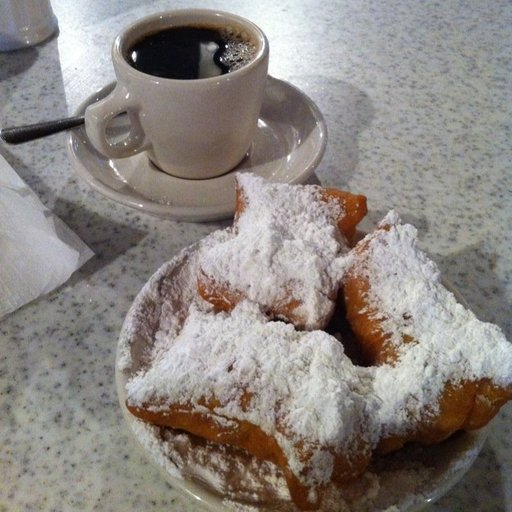

In [ ]:
sample["image"]

That looks tasty. What is it? What does label 6 correspond to in the dataset?

In [ ]:
labels = food["train"].features["label"].names
labels[6]

'beignets'

Yummy! For simplicity, let's create dictionaries from the labels to the class names and vice versa.

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
id2label[str(79)]

'prime_rib'

Let's now pre-process the dataset. We'll use an `AutoImageProcessor` rather than an `AutoTokenizer` to preprocess the images. Just as with tokenizers, the processor is tied to a model. This ensures we pass images in the right format to the model.

In [ ]:
from transformers import AutoImageProcessor

model_id = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_id)

/home/osanseviero/miniconda3/envs/book/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We'll do a few things:

* Make the images to the model's input size (via cropping).
* Convert from a PIL image to a PyTorch tensor.
* Normalize the images.

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (image_processor.size["height"], image_processor.size["width"])

transforms = Compose([
    RandomResizedCrop(size), 
    ToTensor(), 
    normalize
])

With `with_transform`, the dataset will automatically apply the processor to the images.

In [ ]:
def preprocess(examples):
    examples["pixel_values"] = [transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [ ]:
food = food.with_transform(preprocess)

We'll also use the `DefaultDataCollator` to collate the data into batches. This collator does not apply any preprocessing - it just batches the data.

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

We'll evaluate the model with the accuracy metric.

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Finally, let's load the base model. Although not strictly needed, we can add `id2label` and `label2id` to the model. This will help us convert between class names and labels and add this information to the model `config.json` file.

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's now train! Things are similar as before

In [ ]:
batch_size = 8 # change according to GPU

training_args = TrainingArguments(
    "my_food_model",
    num_train_epochs=3,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=5e-5,
    gradient_accumulation_steps=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True, 
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 1.7024, 'grad_norm': 2.4436194896698, 'learning_rate': 1.3157894736842106e-05, 'epoch': 0.08}
{'loss': 1.6588, 'grad_norm': 2.7027907371520996, 'learning_rate': 2.6315789473684212e-05, 'epoch': 0.16}
{'loss': 1.6422, 'grad_norm': 2.306035041809082, 'learning_rate': 3.9473684210526316e-05, 'epoch': 0.24}
{'loss': 1.5112, 'grad_norm': 2.56377911567688, 'learning_rate': 4.9703264094955494e-05, 'epoch': 0.32}
{'loss': 1.4454, 'grad_norm': 2.530302047729492, 'learning_rate': 4.821958456973294e-05, 'epoch': 0.4}
{'loss': 1.2908, 'grad_norm': 2.148864507675171, 'learning_rate': 4.673590504451038e-05, 'epoch': 0.48}
{'loss': 1.1777, 'grad_norm': 1.9504655599594116, 'learning_rate': 4.525222551928784e-05, 'epoch': 0.56}
{'loss': 1.1303, 'grad_norm': 2.628530263900757, 'learning_rate': 4.3768545994065286e-05, 'epoch': 0.64}
{'loss': 1.0136, 'grad_norm': 2.364772081375122, 'learning_rate': 4.228486646884273e-05, 'epoch': 0.72}
{'loss': 0.9379, 'grad_norm': 2.5654566287994385, 'learning_r

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.9265279769897461, 'eval_accuracy': 0.902, 'eval_runtime': 5.1573, 'eval_samples_per_second': 193.899, 'eval_steps_per_second': 24.237, 'epoch': 1.0}
{'loss': 0.8551, 'grad_norm': 1.5647954940795898, 'learning_rate': 3.635014836795252e-05, 'epoch': 1.04}
{'loss': 0.809, 'grad_norm': 2.1012136936187744, 'learning_rate': 3.4866468842729974e-05, 'epoch': 1.12}
{'loss': 0.8138, 'grad_norm': 2.8400421142578125, 'learning_rate': 3.338278931750742e-05, 'epoch': 1.2}
{'loss': 0.7945, 'grad_norm': 2.3346023559570312, 'learning_rate': 3.189910979228487e-05, 'epoch': 1.28}
{'loss': 0.768, 'grad_norm': 2.044175624847412, 'learning_rate': 3.0415430267062318e-05, 'epoch': 1.36}
{'loss': 0.6661, 'grad_norm': 1.722981333732605, 'learning_rate': 2.8931750741839762e-05, 'epoch': 1.44}
{'loss': 0.6932, 'grad_norm': 2.4920620918273926, 'learning_rate': 2.744807121661721e-05, 'epoch': 1.52}
{'loss': 0.678, 'grad_norm': 2.0124385356903076, 'learning_rate': 2.5964391691394662e-05, 'epoch': 1.6

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.6001744866371155, 'eval_accuracy': 0.932, 'eval_runtime': 5.0287, 'eval_samples_per_second': 198.86, 'eval_steps_per_second': 24.858, 'epoch': 2.0}
{'loss': 0.5677, 'grad_norm': 2.257492780685425, 'learning_rate': 1.706231454005935e-05, 'epoch': 2.08}
{'loss': 0.5414, 'grad_norm': 2.460390090942383, 'learning_rate': 1.5578635014836794e-05, 'epoch': 2.16}
{'loss': 0.5125, 'grad_norm': 1.795636534690857, 'learning_rate': 1.4094955489614246e-05, 'epoch': 2.24}
{'loss': 0.5137, 'grad_norm': 1.9970831871032715, 'learning_rate': 1.2611275964391692e-05, 'epoch': 2.32}
{'loss': 0.5269, 'grad_norm': 3.570380449295044, 'learning_rate': 1.112759643916914e-05, 'epoch': 2.4}
{'loss': 0.4861, 'grad_norm': 2.5789620876312256, 'learning_rate': 9.643916913946588e-06, 'epoch': 2.48}
{'loss': 0.4999, 'grad_norm': 2.483332633972168, 'learning_rate': 8.160237388724036e-06, 'epoch': 2.56}
{'loss': 0.4723, 'grad_norm': 2.2358555793762207, 'learning_rate': 6.676557863501484e-06, 'epoch': 2.64}

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.5274758338928223, 'eval_accuracy': 0.931, 'eval_runtime': 5.1788, 'eval_samples_per_second': 193.095, 'eval_steps_per_second': 24.137, 'epoch': 3.0}
{'train_runtime': 170.5751, 'train_samples_per_second': 70.35, 'train_steps_per_second': 2.198, 'train_loss': 0.8159504725138347, 'epoch': 3.0}


TrainOutput(global_step=375, training_loss=0.8159504725138347, metrics={'train_runtime': 170.5751, 'train_samples_per_second': 70.35, 'train_steps_per_second': 2.198, 'total_flos': 9.307289843712e+17, 'train_loss': 0.8159504725138347, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/osanseviero/my_food_model/commit/06bad9185002d79d50de82c443488ddbb7e10127', commit_message='End of training', commit_description='', oid='06bad9185002d79d50de82c443488ddbb7e10127', pr_url=None, pr_revision=None, pr_num=None)

Let's now use the `image-classification` pipeline and try to classify the image from the beginning.

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="osanseviero/my_food_model")
classifier(sample["image"])

[{'label': 'beignets', 'score': 0.743257462978363},
 {'label': 'hamburger', 'score': 0.01331538986414671},
 {'label': 'chicken_wings', 'score': 0.011040257290005684},
 {'label': 'bruschetta', 'score': 0.010375719517469406},
 {'label': 'ramen', 'score': 0.009673028253018856}]

Nice! Feel free to explore:

* Find samples from the validation set for which the model is very confident but mismatches the label. Which one is right?
* Try using other models, such as Swin Transformer, MobileViT or ConvNNeXT.
* Explore creating your own dataset with just 3 clases and 10 images per class. How does the model perform?